In [231]:
%pip install numpy opencv-python matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


In [232]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import log10
import os
from tqdm import tqdm

# Create directory structure
os.makedirs('images', exist_ok=True)
os.makedirs('images/details', exist_ok=True)
os.makedirs('images/details/denoising', exist_ok=True)
os.makedirs('images/details/deblurring', exist_ok=True)
os.makedirs('images/details/pipeline', exist_ok=True)
os.makedirs('images/details/edge_detection', exist_ok=True)
os.makedirs('images/details/analysis', exist_ok=True)

In [233]:
# Degrade Images

# Gaussian
def get_gaussian_kernel(kernel_size=5, sigma=1.0):
    axis = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    x_axis, y_axis = np.meshgrid(axis, axis)
    kernel = np.exp(-(x_axis**2 + y_axis**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def apply_gaussian_blur(image, kernel_size=5, sigma=1.0):
    img = image.astype(np.float32)
    kernel = get_gaussian_kernel(kernel_size, sigma)
    pad = kernel_size // 2

    img_padded = np.pad(img, ((pad, pad), (pad, pad), (0,0)), mode='reflect')
    out = np.zeros_like(img)

    for channel in range(img.shape[2]):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = img_padded[i:i+kernel_size, j:j+kernel_size, channel]
                out[i, j, channel] = np.sum(region * kernel)

    return np.clip(out, 0, 255).astype(np.uint8)

# Periodic Noise
def apply_periodic_noise(image, frequency=32, amplitude=32):
    img = image.astype(np.float32)
    h, w = image.shape[:2]

    x = np.arange(w)
    y = np.arange(h)
    x_axis, y_axis = np.meshgrid(x, y)

    noise_pattern = amplitude * np.sin(2 * np.pi * frequency * (x_axis + y_axis) / (h + w))

    if len(img.shape) == 3:
        noise_pattern = np.stack([noise_pattern] * img.shape[2], axis=2)

    noisy_img = img + noise_pattern
    
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# Low Contrast
def apply_low_contrast(image, low_contrast_factor=0.5):
    img = image.astype(np.float32)

    if len(img.shape) == 3:
        mean = np.mean(img, axis=(0, 1), keepdims=True)
    else:
        mean = np.mean(img)

    low_contrast_img = mean + low_contrast_factor * (img - mean)

    return np.clip(low_contrast_img, 0, 255).astype(np.uint8)


In [ ]:
# Test Gaussian Blur

config = {
    'gaussian_blur': {
        'kernel_size': 11,
        'sigma': 3.0
    },
    'periodic_noise': {
        'frequency': 32,
        'amplitude': 32
    },
    'low_contrast': {
        'low_contrast_factor': 0.3
    }
}

image = cv2.imread('images/chicago.jpg')

degraded_image = image.copy()

degraded_image = apply_gaussian_blur(
    degraded_image, 
    kernel_size=config['gaussian_blur']['kernel_size'],
    sigma=config['gaussian_blur']['sigma']
)

degraded_image = apply_low_contrast(
    degraded_image,
    low_contrast_factor=config['low_contrast']['low_contrast_factor']
)

degraded_image = apply_periodic_noise(
    degraded_image,
    frequency=config['periodic_noise']['frequency'],
    amplitude=config['periodic_noise']['amplitude']
)

cv2.imwrite('images/degraded.png', degraded_image)
cv2.imwrite('images/details/degraded_image.png', degraded_image)


[ WARN:0@105271.055] global loadsave.cpp:275 findDecoder imread_('./chicago.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

Assess contrast
[Standard Deviation]: 25.14
[Dynamic Range]: 126.00


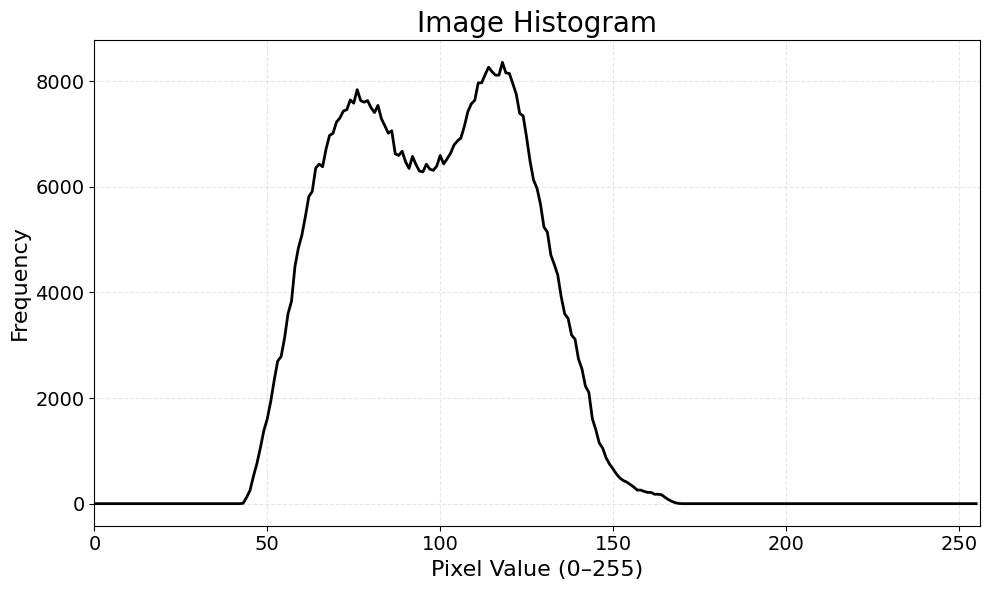

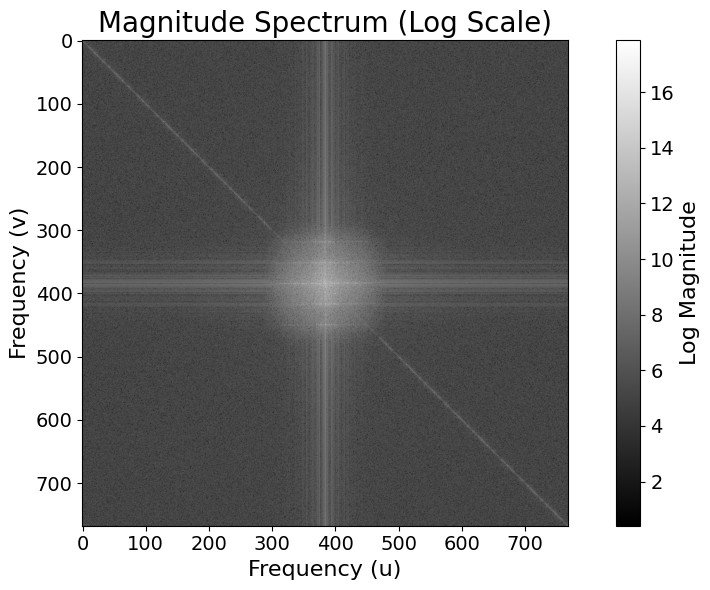


=== Frequency Domain Analysis ===
Center frequency coordinates: (384, 384)

Top 10 frequency peaks (excluding DC component):
Rank | Coordinates (x, y) | Relative to center | Magnitude
----------------------------------------------------------------------
   1 | ( 400,  400) | ( +16,  +16) | 9.37e+06
   2 | ( 368,  368) | ( -16,  -16) | 9.37e+06
   3 | ( 396,  384) | ( +12,   +0) | 7.01e+05
   4 | ( 372,  384) | ( -12,   +0) | 7.01e+05
   5 | ( 399,  384) | ( +15,   +0) | 6.57e+05
   6 | ( 369,  384) | ( -15,   +0) | 6.57e+05
   7 | ( 384,  351) | (  +0,  -33) | 5.34e+05
   8 | ( 384,  417) | (  +0,  +33) | 5.34e+05
   9 | ( 363,  384) | ( -21,   +0) | 4.65e+05
  10 | ( 405,  384) | ( +21,   +0) | 4.65e+05

Max magnitude (excluding DC): 9.37e+06
DC component magnitude: 5.74e+07


In [ ]:
# TODO 1: Image Restoration & Enhancement

# Analysis and Frequency Domain Inspection

def visualize_histogram(image):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()
    
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    
    contrast_std = np.std(gray_image)
    dynamic_range = np.max(gray_image) - np.min(gray_image)
    
    print(f"Assess contrast")
    print(f"[Standard Deviation]: {contrast_std:.2f}")
    print(f"[Dynamic Range]: {dynamic_range:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.title("Image Histogram", fontsize=20)
    plt.xlabel("Pixel Value (0–255)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.plot(hist, color='black', linewidth=2)
    plt.xlim([0, 256])
    plt.grid(alpha=0.3, linestyle="--")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()
    
    return contrast_std, dynamic_range

def analyse_fft(image):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()
    
    fft_result = np.fft.fft2(gray_image)
    fft_shifted = np.fft.fftshift(fft_result)
    
    magnitude_spectrum = np.abs(fft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    # Visualize the magnitude spectrum
    plt.figure(figsize=(10, 6))
    plt.imshow(magnitude_spectrum_log, cmap='gray')
    plt.title('Magnitude Spectrum (Log Scale)', fontsize=20)
    cbar = plt.colorbar(label='Log Magnitude')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Log Magnitude', fontsize=16)
    plt.xlabel('Frequency (u)', fontsize=16)
    plt.ylabel('Frequency (v)', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()
    
    # Identify and print periodic noise peaks
    print("\n=== Frequency Domain Analysis ===")
    
    # Find center coordinates
    center_y, center_x = np.array(magnitude_spectrum.shape) // 2
    print(f"Center frequency coordinates: ({center_x}, {center_y})")
    
    # Create a mask to exclude the DC component (center)
    mask = np.ones_like(magnitude_spectrum, dtype=bool)
    mask_radius = 10  # Exclude center region
    y, x = np.ogrid[:magnitude_spectrum.shape[0], :magnitude_spectrum.shape[1]]
    center_mask = (x - center_x)**2 + (y - center_y)**2 <= mask_radius**2
    mask[center_mask] = False
    
    # Find top peaks (periodic noise)
    masked_spectrum = magnitude_spectrum.copy()
    masked_spectrum[~mask] = 0
    
    # Find top 10 peaks
    flat_indices = np.argsort(masked_spectrum.ravel())[::-1][:10]
    peak_coords = np.unravel_index(flat_indices, magnitude_spectrum.shape)
    
    print("\nTop 10 frequency peaks (excluding DC component):")
    print("Rank | Coordinates (x, y) | Relative to center | Magnitude")
    print("-" * 70)
    
    for i, (y_coord, x_coord) in enumerate(zip(peak_coords[0], peak_coords[1])):
        rel_x = x_coord - center_x
        rel_y = y_coord - center_y
        mag = magnitude_spectrum[y_coord, x_coord]
        print(f"{i+1:4d} | ({x_coord:4d}, {y_coord:4d}) | ({rel_x:+4d}, {rel_y:+4d}) | {mag:.2e}")
    
    # Additional statistics
    print(f"\nMax magnitude (excluding DC): {np.max(masked_spectrum):.2e}")
    print(f"DC component magnitude: {magnitude_spectrum[center_y, center_x]:.2e}")
    
    return fft_shifted, magnitude_spectrum

visualize_histogram(degraded_image)
analyse_fft(degraded_image);

In [ ]:
# Deblurring and Denoising

# Band-Reject Filter

def build_notch_mask(shape, rel_peaks, radius=5, sigma=3.0, soft=True):
    h, w = shape[:2]
    cy, cx = h // 2, w // 2

    unique = set()
    for dx, dy in rel_peaks:
        unique.add((int(dx), int(dy)))
        unique.add((-int(dx), -int(dy)))
    rel_peaks = list(unique)

    y, x = np.ogrid[:h, :w]
    mask = np.ones((h, w), dtype=np.float32)

    for dx, dy in rel_peaks:
        px, py = cx + dx, cy + dy

        d = (x - px)**2 + (y - py)**2

        if soft:
            notch = 1.0 - np.exp(-d / (2.0 * sigma**2))
            mask *= notch
        else:
            mask[d <= radius**2] = 0.0

    return mask


def band_reject_filter(image, rel_peaks, radius=5, sigma=3.0, soft=True):
    img = image.astype(np.float32)
    if img.ndim == 2:
        channels = 1
        img_c = img[..., None]
    else:
        channels = img.shape[2]
        img_c = img

    h, w = img_c.shape[:2]
    mask = build_notch_mask((h, w), rel_peaks, radius, sigma, soft)

    out = np.zeros_like(img_c, dtype=np.float32)
    for c in range(channels):
        fft_result = np.fft.fft2(img_c[..., c])
        fft_shifted = np.fft.fftshift(fft_result)
        fft_shifted_filtered = fft_shifted * mask
        fft_ishifted = np.fft.ifftshift(fft_shifted_filtered)
        f_rec = np.fft.ifft2(fft_ishifted)
        out[..., c] = np.real(f_rec)

    out = np.squeeze(out)
    return np.clip(out, 0, 255).astype(np.uint8)


# Wiener Filter

def create_psf(shape, kernel_size=11, sigma=3.0):
    psf = get_gaussian_kernel(kernel_size, sigma)
    
    h, w = shape
    padded = np.zeros((h, w), dtype=np.float32)
    kh, kw = psf.shape
    padded[:kh, :kw] = psf
    padded = np.roll(padded, -kh//2, axis=0)
    padded = np.roll(padded, -kw//2, axis=1)
    
    return padded


def estimate_snr(image, window_size=64, flat_ratio=0.1, eps=1e-8):
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        gray = image.astype(np.float32)

    H, W = gray.shape
    # Total variance (observed image variance)
    var_y = float(gray.var())

    # Collect patch variances
    patch_vars = []
    for i in range(0, H - window_size + 1, window_size):
        for j in range(0, W - window_size + 1, window_size):
            patch = gray[i:i+window_size, j:j+window_size]
            patch_vars.append(float(patch.var()))

    if not patch_vars:
        return 0.01  # Fallback value

    patch_vars = np.array(patch_vars, dtype=np.float32)
    # Use median of flattest patches (lowest flat_ratio) as noise variance
    k = max(1, int(len(patch_vars) * flat_ratio))
    sigma_n2 = float(np.median(np.partition(patch_vars, k)[:k]))

    # Signal variance = total variance - noise variance (prevent negative)
    sigma_x2 = max(var_y - sigma_n2, eps)

    K = sigma_n2 / sigma_x2
    # Lower bound to prevent divergence
    return float(max(K, 1e-4))


def wiener_deconvolution(image, psf, K=None):
    if K is None:
        K = estimate_snr(image)
        print(f"Estimated noise-to-signal ratio (K): {K:.4f}")
        
    img = image.astype(np.float32)
    if img.ndim == 2:
        channels = 1
        img_c = img[..., None]
    else:
        channels = img.shape[2]
        img_c = img

    out = np.zeros_like(img_c, dtype=np.float32)
    H = np.fft.fft2(psf, s=img.shape[:2])
    H_conj = np.conj(H)
    H_power = np.abs(H)**2

    for c in range(channels):
        G = np.fft.fft2(img_c[..., c])
        wiener_filter = (H_conj / (H_power + K))
        f_hat = wiener_filter * G
        f_restored = np.fft.ifft2(f_hat)
        out[..., c] = np.real(f_restored)

    out = np.squeeze(out)
    return np.clip(out, 0, 255).astype(np.uint8)

In [ ]:
rel_peaks = [(+16, +16)]

denoised_image = band_reject_filter(
    degraded_image,
    rel_peaks=rel_peaks,
    radius=5,
    sigma=3.0,
    soft=True
)

cv2.imwrite('images/details/denoising/denoised_bandreject.png', denoised_image)

psf = create_psf(
    shape=degraded_image.shape[:2],
    kernel_size=config['gaussian_blur']['kernel_size'],
    sigma=config['gaussian_blur']['sigma']
)

restored_img = wiener_deconvolution(
    denoised_image,
    psf=psf,
    K=0.02
)

cv2.imwrite('images/details/deblurring/restored_wiener.png', restored_img)

True

In [ ]:
# Contrast Enhancement & Pipeline Optimization

# Helper function
def _to_gray_float01(img):
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    return (gray.astype(np.float32) / 255.0)

def apply_filter2d(image, kernel):
    img = image.astype(np.float32)
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    
    # Reflect padding
    img_padded = np.pad(img, ((pad, pad), (pad, pad)), mode='reflect')
    
    # Output array
    out = np.zeros_like(img, dtype=np.float32)
    
    # Apply convolution
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = img_padded[i:i+kernel_size, j:j+kernel_size]
            out[i, j] = np.sum(region * kernel)
    
    return out

# Histogram Equalization
def equalize_histogram(img, clipLimit=2.0, tileGridSize=(8,8)):
    image = img.copy()
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    if image.ndim == 2:
        out = clahe.apply(image)
        return out

    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    
    Y_eq = clahe.apply(Y)
    
    merged = cv2.merge([Y_eq, Cr, Cb])
    out = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)
    return out

# Metrics (PSNR, SSIM)
def compute_psnr(gt_img, tgt_img, data_range=255.0):
    ref = gt_img.astype(np.float32)
    cmp_ = tgt_img.astype(np.float32)
    mse = np.mean((ref - cmp_)**2)
    if mse == 0:
        return float('inf')
    return 10.0 * log10((data_range**2) / mse)

def compute_ssim(gt_img, tgt_img):
    x = _to_gray_float01(gt_img)
    y = _to_gray_float01(tgt_img)

    kernel = get_gaussian_kernel(kernel_size=11, sigma=1.5)

    mu_x = apply_filter2d(x, kernel)
    mu_y = apply_filter2d(y, kernel)

    mu_x2 = mu_x * mu_x
    mu_y2 = mu_y * mu_y
    mu_xy = mu_x * mu_y

    sigma_x2 = apply_filter2d(x * x, kernel) - mu_x2
    sigma_y2 = apply_filter2d(y * y, kernel) - mu_y2
    sigma_xy = apply_filter2d(x * y, kernel) - mu_xy

    c1 = (0.01 ** 2)
    c2 = (0.03 ** 2)

    ssim_map = ((2 * mu_xy + c1) * (2 * sigma_xy + c2)) / ((mu_x2 + mu_y2 + c1) * (sigma_x2 + sigma_y2 + c2))
    return float(np.mean(ssim_map))



# Optimize order of operations
def run_pipeline(image,
                 order,
                 rel_peaks,
                 psf_kernel_size,
                 psf_sigma,
                 wiener_K=0.01,
                 notch_radius=5,
                 notch_sigma=3.0,
                 notch_soft=True,
                 clahe_clip=2.0,
                 clahe_tiles=(8,8)):
    img = image.copy()

    psf = create_psf(shape=img.shape[:2], kernel_size=psf_kernel_size, sigma=psf_sigma)

    for step in order:
        if step == "denoise":
            img = band_reject_filter(img, rel_peaks=rel_peaks,
                                     radius=notch_radius, sigma=notch_sigma, soft=notch_soft)
        elif step == "deblur":
            img = wiener_deconvolution(img, psf=psf, K=wiener_K)
        elif step == "enhance":
            img = equalize_histogram(img, clipLimit=clahe_clip, tileGridSize=clahe_tiles)
        else:
            raise ValueError(f"Unknown step: {step}")

    return img


def compare_pipelines(original_clean, degraded,
                      rel_peaks,
                      psf_kernel_size, psf_sigma,
                      wiener_K=0.01):
    orders = {
        "A: Denoise→Deblur→Enhance": ["denoise", "deblur", "enhance"],
        "B: Deblur→Denoise→Enhance": ["deblur", "denoise", "enhance"],
        "C: Denoise→Enhance→Deblur": ["denoise", "enhance", "deblur"],
    }

    results = {}
    for name, order in orders.items():
        out = run_pipeline(
            degraded, order,
            rel_peaks=rel_peaks,
            psf_kernel_size=psf_kernel_size, psf_sigma=psf_sigma,
            wiener_K=wiener_K,
            notch_radius=5, notch_sigma=3.0, notch_soft=True,
            clahe_clip=2.0, clahe_tiles=(8,8)
        )
        psnr = compute_psnr(original_clean, out)
        ssim = compute_ssim(original_clean, out)
        results[name] = (out, psnr, ssim)
        print(f"[{name}]  PSNR: {psnr:.2f} dB  |  SSIM: {ssim:.4f}")

    for name, (img, psnr, ssim) in results.items():
        tag = name.split(":")[0]
        cv2.imwrite(f'images/details/pipeline/restored_{tag}.png', img)

    best = max(results.items(), key=lambda kv: (kv[1][1], kv[1][2]))  # PSNR 우선, SSIM 보조
    print(f"\nBest pipeline by PSNR/SSIM: {best[0]}")

rel_peaks = [(+16, +16)]

# Estimate theoretical K value from degraded image
K_theory = estimate_snr(degraded_image)
print(f"Theoretical K estimation (variance-based): {K_theory:.4f}")
print(f"This value will be included in grid search for comparison.\n")

# Grid search including theoretical estimate
K_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
# Add theoretical K if not already in list
if K_theory not in K_values:
    K_values.append(K_theory)
    K_values.sort()

best_results = {}

for K in tqdm(K_values, desc="Grid Search Progress"):
    print(f"\n{'='*70}")
    print(f"Testing K = {K}")
    print('='*70)
    
    orders = {
        "A: Denoise→Deblur→Enhance": ["denoise", "deblur", "enhance"],
        "B: Deblur→Denoise→Enhance": ["deblur", "denoise", "enhance"],
        "C: Denoise→Enhance→Deblur": ["denoise", "enhance", "deblur"],
    }
    
    for name, order in orders.items():
        out = run_pipeline(
            degraded_image, order,
            rel_peaks=rel_peaks,
            psf_kernel_size=config['gaussian_blur']['kernel_size'],
            psf_sigma=config['gaussian_blur']['sigma'],
            wiener_K=K,
            notch_radius=5, notch_sigma=3.0, notch_soft=True,
            clahe_clip=2.0, clahe_tiles=(8,8)
        )
        psnr = compute_psnr(image, out)
        ssim = compute_ssim(image, out)
        
        key = (K, name)
        best_results[key] = (psnr, ssim, out)  # Store image as well
        print(f"[{name}]  PSNR: {psnr:.2f} dB  |  SSIM: {ssim:.4f}")

print(f"\n{'='*70}")
print("SUMMARY: Best Results")
print('='*70)

# Find best overall
best_key = max(best_results.items(), key=lambda x: (x[1][0], x[1][1]))[0]
best_psnr, best_ssim, best_img = best_results[best_key]
print(f"\nBest configuration:")
print(f"K = {best_key[0]}")
print(f"Pipeline: {best_key[1]}")
print(f"PSNR: {best_psnr:.2f} dB  |  SSIM: {best_ssim:.4f}")

# Compare theoretical vs empirical optimal
print(f"\nTheoretical vs Empirical Comparison:")
print(f"K_theory (variance-based): {K_theory:.4f}")
print(f"K_optimal (grid search):   {best_key[0]:.4f}")
if abs(K_theory - best_key[0]) / K_theory < 0.5:
    print("The theoretical estimate is within the same order of magnitude as the empirical optimum.")

# Best per pipeline
print(f"\nBest K for each pipeline:")
for pipeline_name in ["A: Denoise→Deblur→Enhance", "B: Deblur→Denoise→Enhance", "C: Denoise→Enhance→Deblur"]:
    pipeline_results = {k: v for k, v in best_results.items() if k[1] == pipeline_name}
    best_k = max(pipeline_results.items(), key=lambda x: (x[1][0], x[1][1]))[0]
    psnr, ssim, img = pipeline_results[best_k]
    print(f"{pipeline_name}: K={best_k[0]:.4f}, PSNR={psnr:.2f}, SSIM={ssim:.4f}")
    
    # Save best result image for each pipeline
    tag = pipeline_name.split(":")[0]
    cv2.imwrite(f'images/details/pipeline/restored_{tag}.png', img)

# Save overall best result as restored.png (Submission requirement)
cv2.imwrite('images/restored.png', best_img)  # Submission requirement
cv2.imwrite('images/details/pipeline/restored_best.png', best_img)  # Detailed version

Theoretical K estimation (variance-based): 3.6616
This value will be included in grid search for comparison.



Grid Search Progress:   0%|          | 0/11 [00:00<?, ?it/s]


Testing K = 0.0001
[A: Denoise→Deblur→Enhance]  PSNR: 15.41 dB  |  SSIM: 0.2625
[B: Deblur→Denoise→Enhance]  PSNR: 15.55 dB  |  SSIM: 0.2756


Grid Search Progress:   9%|▉         | 1/11 [00:27<04:30, 27.04s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 14.38 dB  |  SSIM: 0.1990

Testing K = 0.0005
[A: Denoise→Deblur→Enhance]  PSNR: 17.73 dB  |  SSIM: 0.3954
[B: Deblur→Denoise→Enhance]  PSNR: 17.80 dB  |  SSIM: 0.4034


Grid Search Progress:  18%|█▊        | 2/11 [00:54<04:02, 27.00s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 17.26 dB  |  SSIM: 0.3500

Testing K = 0.001
[A: Denoise→Deblur→Enhance]  PSNR: 18.42 dB  |  SSIM: 0.4357
[B: Deblur→Denoise→Enhance]  PSNR: 18.47 dB  |  SSIM: 0.4411


Grid Search Progress:  27%|██▋       | 3/11 [01:20<03:35, 26.99s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 18.16 dB  |  SSIM: 0.4081

Testing K = 0.005
[A: Denoise→Deblur→Enhance]  PSNR: 19.32 dB  |  SSIM: 0.4731
[B: Deblur→Denoise→Enhance]  PSNR: 19.33 dB  |  SSIM: 0.4740


Grid Search Progress:  36%|███▋      | 4/11 [01:48<03:09, 27.08s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 19.42 dB  |  SSIM: 0.4715

Testing K = 0.01
[A: Denoise→Deblur→Enhance]  PSNR: 19.43 dB  |  SSIM: 0.4732
[B: Deblur→Denoise→Enhance]  PSNR: 19.43 dB  |  SSIM: 0.4735


Grid Search Progress:  45%|████▌     | 5/11 [02:15<02:42, 27.10s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 19.59 dB  |  SSIM: 0.4746

Testing K = 0.02
[A: Denoise→Deblur→Enhance]  PSNR: 19.45 dB  |  SSIM: 0.4675
[B: Deblur→Denoise→Enhance]  PSNR: 19.46 dB  |  SSIM: 0.4676


Grid Search Progress:  55%|█████▍    | 6/11 [02:43<02:17, 27.40s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 19.60 dB  |  SSIM: 0.4699

Testing K = 0.05
[A: Denoise→Deblur→Enhance]  PSNR: 19.34 dB  |  SSIM: 0.4509
[B: Deblur→Denoise→Enhance]  PSNR: 19.35 dB  |  SSIM: 0.4505


Grid Search Progress:  64%|██████▎   | 7/11 [03:10<01:49, 27.42s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 19.43 dB  |  SSIM: 0.4536

Testing K = 0.1
[A: Denoise→Deblur→Enhance]  PSNR: 19.09 dB  |  SSIM: 0.4303
[B: Deblur→Denoise→Enhance]  PSNR: 19.09 dB  |  SSIM: 0.4299


Grid Search Progress:  73%|███████▎  | 8/11 [03:37<01:21, 27.31s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 18.98 dB  |  SSIM: 0.4318

Testing K = 0.2
[A: Denoise→Deblur→Enhance]  PSNR: 18.43 dB  |  SSIM: 0.4014
[B: Deblur→Denoise→Enhance]  PSNR: 18.43 dB  |  SSIM: 0.4008


Grid Search Progress:  82%|████████▏ | 9/11 [04:04<00:54, 27.22s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 17.90 dB  |  SSIM: 0.3996

Testing K = 0.5
[A: Denoise→Deblur→Enhance]  PSNR: 16.29 dB  |  SSIM: 0.3471
[B: Deblur→Denoise→Enhance]  PSNR: 16.27 dB  |  SSIM: 0.3462


Grid Search Progress:  91%|█████████ | 10/11 [04:31<00:27, 27.14s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 15.14 dB  |  SSIM: 0.3358

Testing K = 3.661613297799091
[A: Denoise→Deblur→Enhance]  PSNR: 10.08 dB  |  SSIM: 0.1560
[B: Deblur→Denoise→Enhance]  PSNR: 10.07 dB  |  SSIM: 0.1546


Grid Search Progress: 100%|██████████| 11/11 [04:58<00:00, 27.17s/it]

[C: Denoise→Enhance→Deblur]  PSNR: 9.39 dB  |  SSIM: 0.1191

SUMMARY: Best Results

Best configuration:
K = 0.02
Pipeline: C: Denoise→Enhance→Deblur
PSNR: 19.60 dB  |  SSIM: 0.4699

Theoretical vs Empirical Comparison:
K_theory (variance-based): 3.6616
K_optimal (grid search):   0.0200

Best K for each pipeline:
A: Denoise→Deblur→Enhance: K=0.0200, PSNR=19.45, SSIM=0.4675
B: Deblur→Denoise→Enhance: K=0.0200, PSNR=19.46, SSIM=0.4676
C: Denoise→Enhance→Deblur: K=0.0200, PSNR=19.60, SSIM=0.4699


True

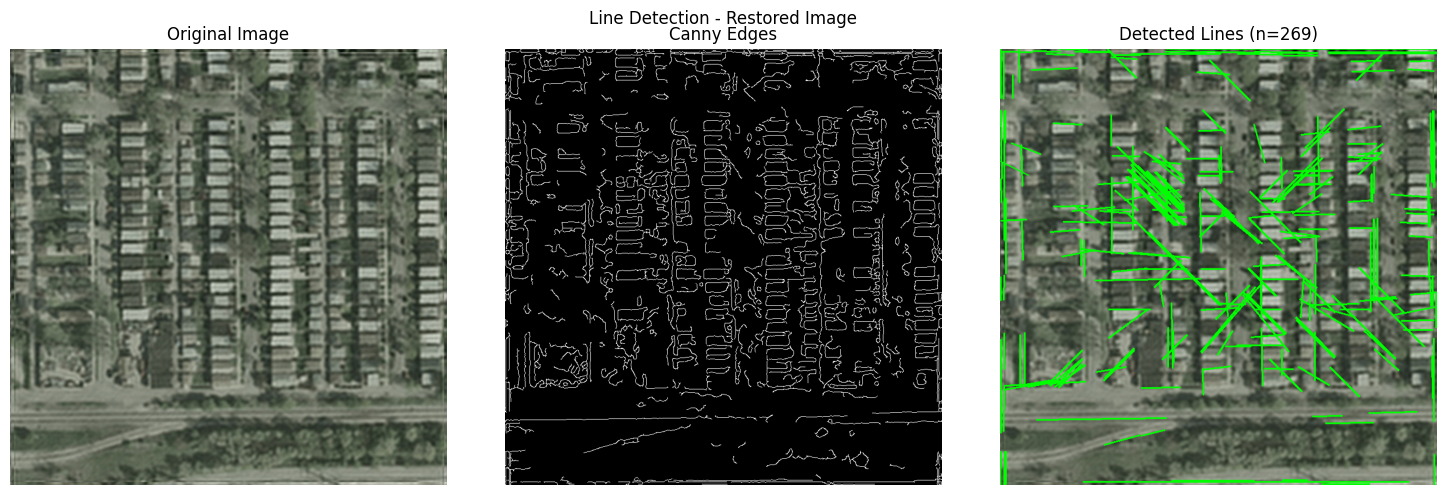

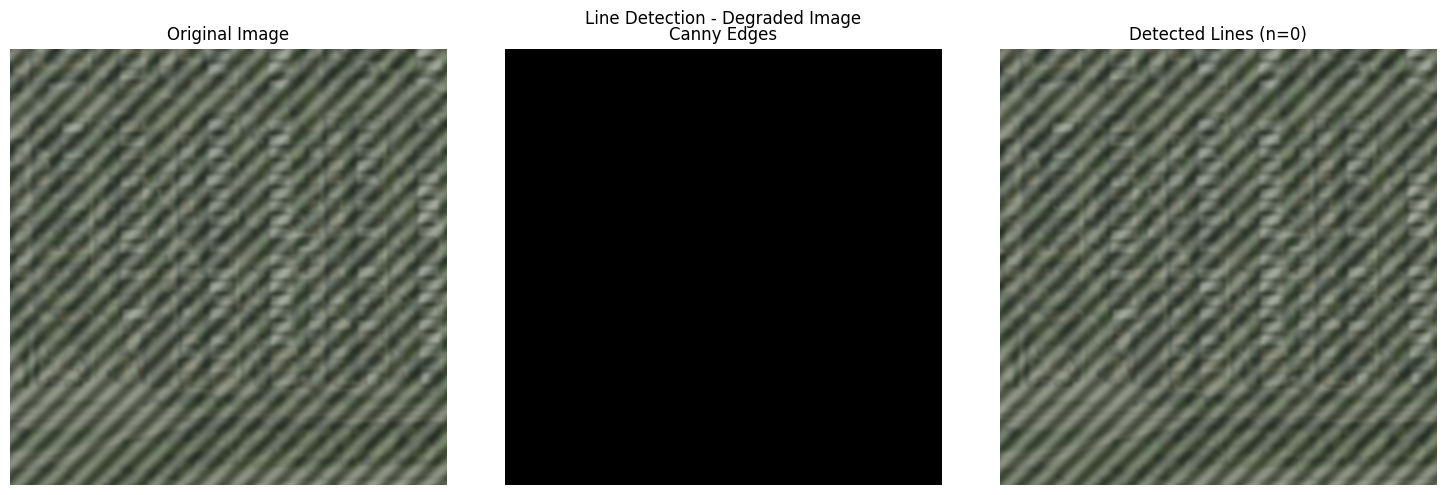

True

In [ ]:
# TODO 2: Information Extraction & Quantitative Analysis

# Structural Feature Detection

def detect_lines(image, canny_low=50, canny_high=150, 
                 hough_threshold=100, min_line_length=50, max_line_gap=10):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    edges = cv2.Canny(gray, canny_low, canny_high)
    
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, 
                           threshold=hough_threshold,
                           minLineLength=min_line_length, 
                           maxLineGap=max_line_gap)
    
    return edges, lines


def visualize_line_detection(image, edges, lines, title="Line Detection"):
    result = image.copy()
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edges')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Lines (n={len(lines) if lines is not None else 0})')
    plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


restored_image = cv2.imread('images/restored.png')

edges_restored, lines_restored = detect_lines(
    restored_image, 
    canny_low=50, 
    canny_high=150,
    hough_threshold=80,
    min_line_length=40,
    max_line_gap=15
)

visualize_line_detection(restored_image, edges_restored, lines_restored, 
                        title="Line Detection - Restored Image")

# Save restored image results
cv2.imwrite('images/details/edge_detection/restored_edges.png', edges_restored)

result_restored = restored_image.copy()
if lines_restored is not None:
    for line in lines_restored:
        x1, y1, x2, y2 = line[0]
        cv2.line(result_restored, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite('images/details/edge_detection/restored_lines.png', result_restored)
cv2.imwrite('images/road_detection.png', result_restored)  # Key result for submission

edges_degraded, lines_degraded = detect_lines(
    degraded_image,
    canny_low=50,
    canny_high=150,
    hough_threshold=80,
    min_line_length=40,
    max_line_gap=15
)

visualize_line_detection(degraded_image, edges_degraded, lines_degraded,
                        title="Line Detection - Degraded Image")

# Save degraded image results
cv2.imwrite('images/details/edge_detection/degraded_edges.png', edges_degraded)

result_degraded = degraded_image.copy()
if lines_degraded is not None:
    for line in lines_degraded:
        x1, y1, x2, y2 = line[0]
        cv2.line(result_degraded, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite('images/details/edge_detection/degraded_lines.png', result_degraded)


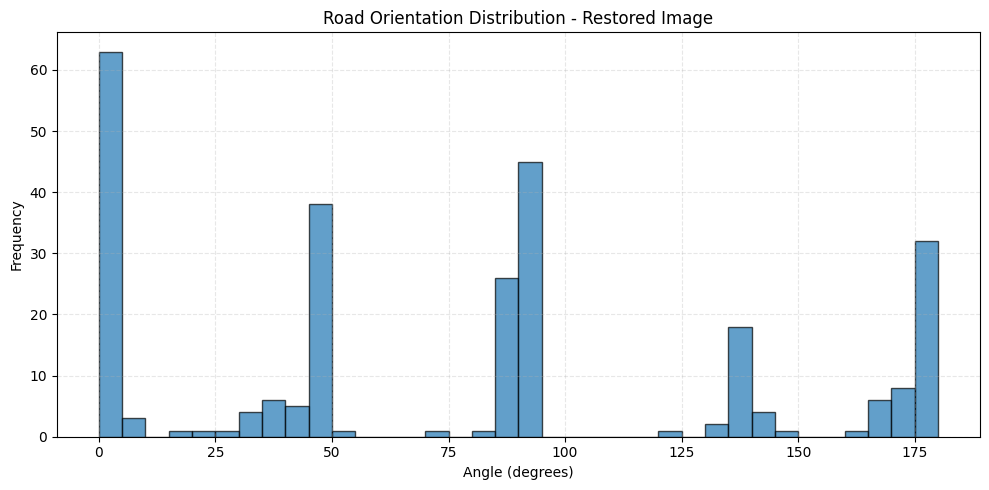

Total detected lines: 269
Mean angle: 77.32 degrees
Standard deviation: 61.30 degrees

Road density (full image): 0.036651 pixels/pixel^2
Road density (center 512x512 ROI): 0.048927 pixels/pixel^2


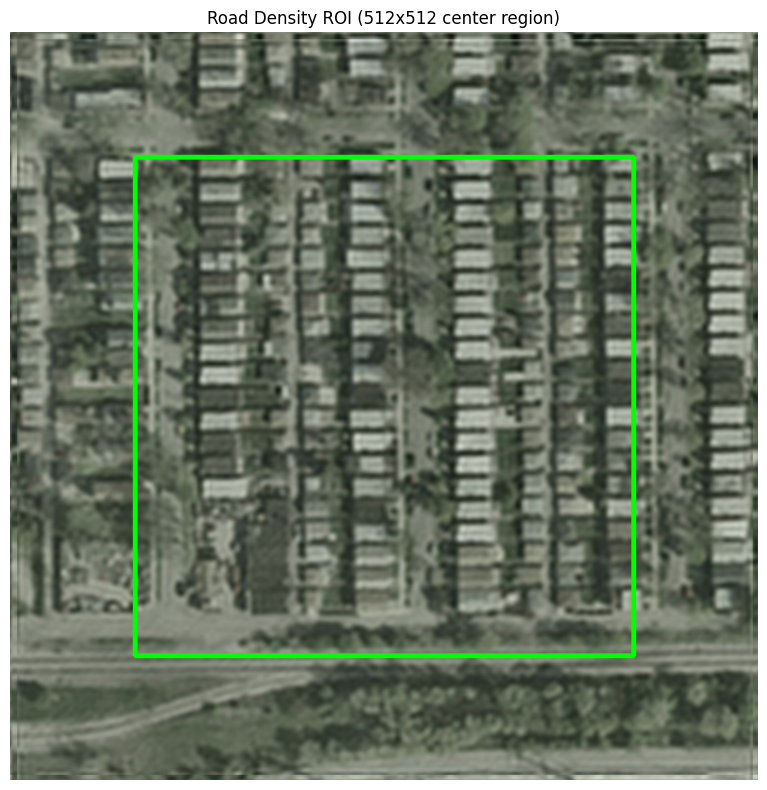


Detected intersections: 288


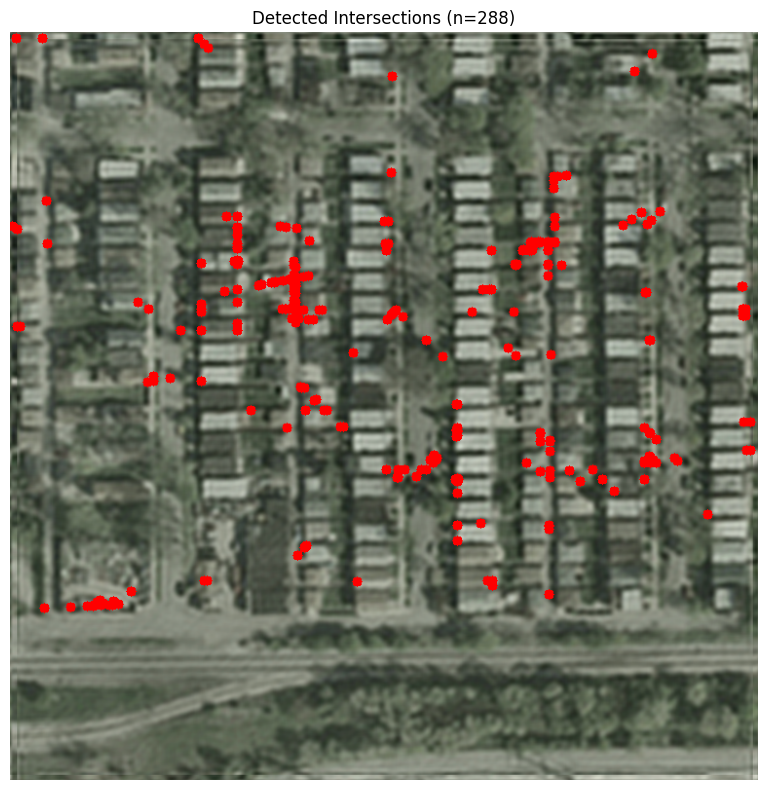

In [ ]:
# Quantitative Analysis

def calculate_line_angles(lines):
    if lines is None:
        return np.array([])
    
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        angle = angle % 180
        angles.append(angle)
    
    return np.array(angles)


def plot_angle_histogram(angles, title="Road Orientation Distribution"):
    plt.figure(figsize=(10, 5))
    plt.hist(angles, bins=36, range=(0, 180), edgecolor='black', alpha=0.7)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print(f"Total detected lines: {len(angles)}")
    print(f"Mean angle: {np.mean(angles):.2f} degrees")
    print(f"Standard deviation: {np.std(angles):.2f} degrees")


def segment_intersects_rect(x1, y1, x2, y2, x_min, y_min, x_max, y_max):
    if (x_min <= x1 < x_max and y_min <= y1 < y_max) or \
       (x_min <= x2 < x_max and y_min <= y2 < y_max):
        return True
    
    def ccw(ax, ay, bx, by, cx, cy):
        return (cy - ay) * (bx - ax) > (by - ay) * (cx - ax)
    
    def segments_intersect(ax, ay, bx, by, cx, cy, dx, dy):
        return ccw(ax, ay, cx, cy, dx, dy) != ccw(bx, by, cx, cy, dx, dy) and \
               ccw(ax, ay, bx, by, cx, cy) != ccw(ax, ay, bx, by, dx, dy)
    
    edges = [
        (x_min, y_min, x_max, y_min),
        (x_max, y_min, x_max, y_max),
        (x_max, y_max, x_min, y_max),
        (x_min, y_max, x_min, y_min)
    ]
    
    for ex1, ey1, ex2, ey2 in edges:
        if segments_intersect(x1, y1, x2, y2, ex1, ey1, ex2, ey2):
            return True
    
    return False


def estimate_road_density(lines, image_shape, region=None):
    if lines is None:
        return 0.0
    
    h, w = image_shape[:2]
    
    if region is None:
        region = (0, 0, w, h)
    
    x_min, y_min, x_max, y_max = region
    region_area = (x_max - x_min) * (y_max - y_min)
    
    total_length = 0.0
    for line in lines:
        x1, y1, x2, y2 = map(int, line[0])
        
        if segment_intersects_rect(x1, y1, x2, y2, x_min, y_min, x_max, y_max):
            total_length += np.hypot(x2 - x1, y2 - y1)
    
    return total_length / max(region_area, 1)


def find_intersections(lines, distance_threshold=10):
    if lines is None or len(lines) < 2:
        return []
    
    intersections = []
    
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]
            
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            
            if abs(denom) < 1e-6:
                continue
            
            t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
            u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
            
            if 0 <= t <= 1 and 0 <= u <= 1:
                px = x1 + t * (x2 - x1)
                py = y1 + t * (y2 - y1)
                intersections.append((int(px), int(py)))
    
    return intersections


angles_restored = calculate_line_angles(lines_restored)
plot_angle_histogram(angles_restored, title="Road Orientation Distribution - Restored Image")

h, w = restored_image.shape[:2]
roi_center = (w//2 - 256, h//2 - 256, w//2 + 256, h//2 + 256)

density_full = estimate_road_density(lines_restored, restored_image.shape)
density_roi = estimate_road_density(lines_restored, restored_image.shape, region=roi_center)

print(f"\nRoad density (full image): {density_full:.6f} pixels/pixel^2")
print(f"Road density (center 512x512 ROI): {density_roi:.6f} pixels/pixel^2")

# Visualize ROI on image
roi_vis = restored_image.copy()
x_min, y_min, x_max, y_max = roi_center
cv2.rectangle(roi_vis, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
cv2.imwrite('images/details/analysis/roi_visualization.png', roi_vis)
cv2.imwrite('images/road_density_roi.png', roi_vis)  # Key result for submission

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB))
plt.title(f'Road Density ROI (512x512 center region)')
plt.axis('off')
plt.tight_layout()
plt.show()

intersections = find_intersections(lines_restored, distance_threshold=15)
print(f"\nDetected intersections: {len(intersections)}")

if len(intersections) > 0:
    result_with_intersections = restored_image.copy()
    for px, py in intersections:
        cv2.circle(result_with_intersections, (px, py), 5, (0, 0, 255), -1)
    
    # Save intersection image
    cv2.imwrite('images/details/analysis/intersections.png', result_with_intersections)
    cv2.imwrite('images/road_intersections.png', result_with_intersections)  # Key result for submission
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_with_intersections, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Intersections (n={len(intersections)})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()